#**1.Mounting the Drive**
We will be able to save and read from our drive.
It's where the data is stored.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2.Importing all the libraries needed**

In [ ]:
import numpy as np # NumPy is a Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.

import pandas as pd # Pandas is a Python library for data analysis. Data processing, CSV file I/O (e.g. pd.read_csv). Importing the dataset

import matplotlib.pyplot as plt # matplotlib. pyplot is a collection of functions that make matplotlib work like MATLAB.

import seaborn as sns # Seaborn is an open-source Python library built on top of matplotlib. It is used for data visualization and exploratory data analysis.
# Matplotlib: Matplotlib is mainly deployed for basic plotting. Visualization using Matplotlib generally consists of bars, pies, lines, scatter plots and so on. Seaborn: Seaborn, on the other hand, provides a variety of visualization patterns. It uses fewer syntax and has easily interesting default themes

!pip install text_hammer
import text_hammer as th # To facilitate text preprocessing

from tqdm._tqdm_notebook import tqdm_notebook # IPython/Jupyter Notebook progressbar decorator for iterators

!pip install gensim
import gensim.downloader as api # This module is an API for downloading, getting information and loading datasets/models.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical #Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.preprocessing.text import Tokenizer # Transforms each text in texts to a sequence of integers. Each item in texts can also be a list, in which case we assume each item of that list to be a token.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Pads sequences to the same length.
from tensorflow.keras.models import Sequential # A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional # Just your regular densely-connected NN layer, Long Short-Term Memory layer, Turns positive integers (indexes) into dense vectors of fixed size, Bidirectional wrapper for RNNs.
from tensorflow.keras.layers import Dropout # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #Callback to save the Keras model or model weights at some frequency. Stop training when a monitored metric has stopped improving, ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
from tensorflow.keras.models import load_model # Parses a JSON model configuration string and returns a model instance.

import pickle # The pickle module implements binary protocols for serializing and de-serializing a Python object structure.

from sklearn import metrics # The sklearn. metrics module implements several loss, score, and utility functions to measure classification performance.

import warnings # To hide some unnecessary warnings shown by Jupyter

In [ ]:
#import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

#**3.Loading the Data for Emotion Detection** 
The dataset used is downloaded from "https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp". The dataset contains 3 files: train file, test file, Val file.

We start with loading our textual data in a data frame.

In [ ]:
# importing the dataset 
df_train = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/TER/Data/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/TER/Data/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('../content/drive/MyDrive/Colab Notebooks/TER/Data/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [ ]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


We check the category-wise distribution of data.

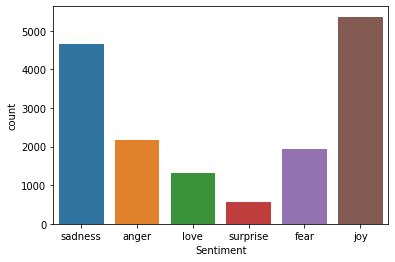

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns
sns.countplot(df_train.Sentiment)
plt.show()

The category Surprise has the least data sample, you can make data balanced by balancing all categories either by over-sampling or under-sampling.

##**3.1.Emotion Detection Data**
In order to make our text data cleaner we need to perform some text preprocessing.
* Removing punctuations (it doesn’t 
contribute to emotion detection).
* Removing stopwords ( i.e. words like the, are, etc. which also does not contribute to the task).
* Removing emails, HTML tags, website, and unnecessary links.
* Removing contraction of words ( I’m -> I am ).
* Normalisation of words ( eating -> eat, playing -> play).

In [ ]:
#!pip install text_hammer 
#import text_hammer as th

     |████████████████████████████████| 115 kB 7.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


Importing **tqdm progress bar** and creating a function which takes data-frame to perform preprocessing and return a preprocessed data-frame.

In [ ]:
%%time
#from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

CPU times: user 664 µs, sys: 0 ns, total: 664 µs
Wall time: 677 µs


In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

* The method **progress_apply()** is used when we create a progress bar associated with the method apply().

* **lambda** function takes a sentence and passes it into text_preprocessing methods.

* **th.make_base()** takes a sentence and returns normalized sentence.

* **th.remove_accented_chars()** removes accented characters.

After building text-preprocessing function we need to call it on our dataframe. only training data need to be cleaned, not test and validation data.

* **“Input”** is the column containing our text data .
calling tEmotionffffext_preprocessing may take time depeding on the data size.

In [ ]:
df_cleaned_train = text_preprocessing(df_train, 'Input')

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

##**3.2.Label Encoding**
The sentiment category in our data frame needs to be converted into some numbers in order to pass into the model.

Using a dictionary we are encoding our sentiment categories **{‘joy’:0,’anger’:1,’love’:2,’sadness’:3,’fear’:4,’surprise’:5}**.

In [ ]:
df_cleaned_train['Sentiment'] = df_cleaned_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment'] = df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment'] = df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
encoded_dict  = {'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}

we have encoded our category by assigning them numbers now it’s time to convert categories into categorical data.

In [ ]:
#from tensorflow.keras.utils import to_categorical
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

**y_val, y_test, y_train** are now a binary matrix that will be passed in our model.

##**3.3.Tokenization**
As you see we have converted our sentiment labels into some numbers and then into a binary matrix, but what about our text data? we can’t pass text directly to our model.

So it’s time to convert our text corpus into some integer numbers.

Tokenizer class converts a sentence into an array of numbers by assigning them numbers based on their frequency.

In [ ]:
#from keras.preprocessing.text import Tokenizer
max_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(max_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

* Only the top **“max_words”** i.e. most frequent words will be taken into account. Only words known by the tokenizer will be taken into account hence we have concatenated our train and test data to increase the vocabulary for the tokenizer.

* The method **fit_on_texts()** fits the text data to the tokenizer. It takes a list of sentences.

In [ ]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input']) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

* **texts_to_sequence()** takes a list of sentences and converts them into a sequence of numbers.

* Since in our data different sentences have different lengths, it means the number sequence made by **texts_to_sequence** will also have different lengths. in order to pass them in our model, we must make all of them of the same length.

* **pad_sequences** is used to ensure that all sequences in a list have the same length. By default, this is done by padding 0 at the beginning/end (**pre, post**) of each sequence until each sequence has the same length as the longest sequence. If in case the sequence length is greater than **maxlen**, it also trims from the end.

In [ ]:
X_train_pad.shape

(16000, 300)

In [ ]:
X_test_pad.shape

(2000, 300)

In [ ]:
X_val_pad.shape

(2000, 300)

Now we have lists containing our sequences of the same length.

##**3.4.Word2Ve**

Before proceeding to the next step, you need to look back to the last step there is one problem in our approach.

Let’s say we have words (‘love’, ‘affection’,’ like’) these words have the same meaning but according to our tokenizer these words are treated differently. we need to create a relationship between all those words
which are interrelated.

Here word embedding comes into play, for more understanding read here.

We are going to use glove-wiki-gigaword-100 which is trained on Wikipedia data and maps a word into an array of length 100. we also have glove-wiki-gigaword-300 which gives a better result but it’s computationally heavy because of higher dimension.

Loading the pertained glove vector using the gensim library.

In [ ]:
#!pip install gensim
#import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

[==================================================] 100.0% 128.1/128.1MB downloaded


More dimension means more deep meaning of words but it may take a longer time to download.

Now map the vocabulary learned by the tokenizer and create a weight matrix.

In [ ]:
vector_size = 100
gensim_weight_matrix = np.zeros((max_words ,vector_size))
gensim_weight_matrix.shape

(10000, 100)

In [ ]:
for word, index in tokenizer.word_index.items():
    if index < max_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

* **tokenizer.word_index.items()** returns a dictionary of unique words as key and frequency as value.

* Iterating the unique words and finding the corresponding word in **glove_gensim.wv.vocab**

* **glove_gensim[‘DOG’]** returns the word vector for ‘DOG’.

* If a word is found in glove vocabulary then return the corresponding vector and append it in **gensim_weight_matrix**.

* **gensim_weight_matrix** must have the size of (number of unique words, glove_dimension).

#**4.Emotion Detection Model Building**
So far we preprocessed our data, converted our **y_label** into categorical data, mapped our vocabulary into the vector using word2vec.

It’s time to design our Bi-LSTM model.

Importing libraries needed.

In [ ]:
#from tensorflow.keras.models import Sequential 
#from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
#import tensorflow
#from tensorflow.keras.layers import Dropout

**Embedding Layer:** we already have created a word-embedding matrix. to feed our word_embedding matrix in our training we would use an embedding layer.

There are 3 parameters in embedding layers.

* **input_dim** : Vocabulary Size( number of unique words for training)

* **output_dim** : Length of the vector for each word(embedding dimension)

* **input_length** : Maximum length of a sequence

* **trainable** : It’s False, which means it will only use a given weight matrix.

In [ ]:
X_train_pad.shape[1]

300

In [ ]:
EMBEDDING_DIM = 100
class_num = 6
model = Sequential()
model.add(Embedding(input_dim = max_words,output_dim = EMBEDDING_DIM,input_length= X_train_pad.shape[1],weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

* **EMBEDDING_DIM = 100** means the embedding layer will create a vector in 100 dimensions.

* While Stacking RNN, the former RNN layers should be set **return_sequences** to True so that the following RNN layer layers can have the full sequence as input.

* **class_num = 6** since we have 6 categories to classify.

## **4.1.Defining Callbacks**

In order to train efficiently, we defined some callbacks.

To avoid the overfitting we use the early stop with the callbacks.

In [ ]:
#EarlyStopping and ModelCheckpoint
#from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('../content/drive/MyDrive/Colab Notebooks/TER/Data/model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

* **EarlyStopping** stops the training after some patience if no further improvement is observed or if training loss decreases and validation loss increases after a certain point.

* **ModelChckpoint** saves the model checkpoint.

## **4.2.Training model**

Now we are ready to train our designed model.

In [ ]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, callbacks= [es, mc])

Epoch 1/25
134/134 [==============================] - ETA: 0s - loss: 1.4328 - accuracy: 0.4430
Epoch 00001: val_accuracy improved from -inf to 0.58100, saving model to ./model.h5
134/134 [==============================] - 1045s 8s/step - loss: 1.4328 - accuracy: 0.4430 - val_loss: 1.2241 - val_accuracy: 0.5810
Epoch 2/25
134/134 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.5957
Epoch 00002: val_accuracy improved from 0.58100 to 0.68650, saving model to ./model.h5
134/134 [==============================] - 1002s 7s/step - loss: 1.1023 - accuracy: 0.5957 - val_loss: 0.8883 - val_accuracy: 0.6865
Epoch 3/25
134/134 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.7048
Epoch 00003: val_accuracy improved from 0.68650 to 0.77900, saving model to ./model.h5
134/134 [==============================] - 996s 7s/step - loss: 0.8126 - accuracy: 0.7048 - val_loss: 0.6033 - val_accuracy: 0.7790
Epoch 4/25
134/134 [==============================] - ET

**history_embedding** keeps the history of model training.


**JSON** is a simple file format for describing data hierarchically.

Keras provides the ability to describe any model using JSON format with a **to_json()** function. This can be saved to file and later loaded via the **model_from_json()** function that will create a new model from the JSON specification.

The weights are saved directly from the model using the **save_weights()** function and later loaded using the symmetrical load_weights() function.

In [ ]:
#save model
fer_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/RNN/ter.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/RNN/ter.h5")

##**4.3.Save Keras Tokenizer**
The tokenizer will transform the text into vectors, it’s important to have the same vector space between training & predicting. The most common way is to save tokenizer and load the same tokenizer at predicting time using pickle.

In [ ]:
#import pickle

with open('../content/drive/MyDrive/Colab Notebooks/TER/Data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

##**4.4.Plotting the History**

Using training history analyzing the model performance. 

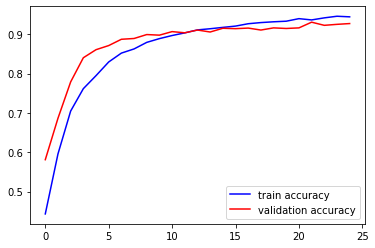

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

#**5.Load Keras Model for Prediction**
Saved models can be re-instantiated via keras.models.load_model().

The model returned by **load_model()** is a compiled model ready to be used.

You have to load both a model and a tokenizer in order to predict new data.

In [ ]:
#from tensorflow import keras
#from keras.models import load_model

In [ ]:
#load model
#model = keras.models.load_model('../content/drive/MyDrive/Colab Notebooks/TER/Data/model.h5')
#load tokenizer
#with open('../content/drive/MyDrive/Colab Notebooks/TER/Data/tokenizer.pickle', 'rb') as handle:
#    loaded_tokenizer = pickle.load(handle)


In [ ]:
from keras.models import model_from_json
#load model
model = model_from_json(open("../content/drive/MyDrive/Colab Notebooks/TER/Data/ter.json", "r").read())
#load weights
model.load_weights('../content/drive/MyDrive/Colab Notebooks/TER/Data/ter.h5')

#load tokenizer
with open('../content/drive/MyDrive/Colab Notebooks/TER/Data/tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

You must use the same Tokenizer you used to build your model. Else this will give different vector to each word at time prediction. The pickle loaded tokenizer is ready to use.

##**5.1.Test the Emotion Detection Model**
We have prepared **X_test_pad** for testing purposes, it’s time to test on it.

* **np.argmax** returns the index of maximum probability.

In [ ]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
#from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       695
           1       0.91      0.91      0.91       275
           2       0.86      0.82      0.84       165
           3       0.94      0.95      0.95       570
           4       0.93      0.88      0.90       238
           5       0.70      0.81      0.75        57

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



wow! it really performed well, as you see this is the result we got using our test data.

##**5.2.Predict New Text emotion**
Now for scoring, We are using a load model, we were able to save the tokenizer and model to a file and load from a file. Without this, we’ll have to process the corpus every time we need to score even a single sentence.

In [ ]:
txt = input(str('input the text:  \n'))
#seq= loaded_tokenizer.texts_to_sequences([txt])
#padded = keras.preprocessing.sequence.pad_sequences(seq, maxlen=None)
#pred = model.predict(padded)*100
#print(pred)
seq= loaded_tokenizer.texts_to_sequences([txt])
padded = pad_sequences(seq, maxlen=None)
pred = model.predict(padded)*100
print(pred)

input the text:  
i still sit back and feel amazed by the whole thing
[[1.3294815e-01 1.9794267e-03 1.5259669e-02 1.4078754e-02 4.1892037e-02
  9.9793831e+01]]


In [ ]:
for key , value in zip(encoded_dict.keys(),pred[0]):
  print(key,value)

joy 0.13294815
anger 0.0019794267
love 0.015259669
sadness 0.014078754
fear 0.041892037
surprise 99.79383


In [ ]:
max = 0
key_max = ""
for key , value in zip(encoded_dict.keys(),pred[0]):
  if max <= value:
    max = value
    key_max = key
print(key_max,max)
    

surprise 99.79383


#**Conclusion**
This is how you can create an emotion detection model, let’s recheck the whole pipeline again:

* Take the input text.

* Use tokenizer converts into integer sequence.

* Use pad_sequence to make sequence length equal to the length used for training.

* Now pass the padded_sequence to model and call predict method, it will give you class index.

* Using the dictionary we defined earlier change the class index to the class label.

you can improve results further by using the BERT State of the Art model and by using word embeddings of higher dimensions ie 300 you can improve further.

{'love', 'anger', 'fear', 'joy', 'sadness', 'surprise'}


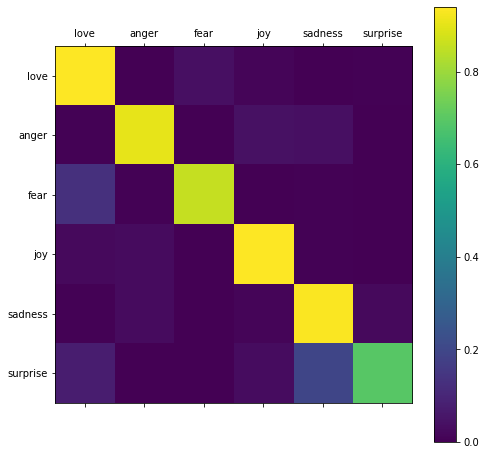

In [ ]:
classes = {'joy','anger','love','sadness','fear','surprise'}
print(classes)
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
show_confusion_matrix(y_true, y_pred, list(classes))